# Akita Tutorial: CTCF Insertions into Neutral Background Sequence
 
This tutorial demonstrates usage of [akita_utils](https://github.com/Fudenberg-Research-Group/akita_utils) to perform CTCF insertions into a neutral background sequence.
    
This involves:

1. Loading the trained model
2. Opening the relevant genome
3. Loading background sequences
4. Reading tsv table with CTCF sites' genomic coordinates
5. Setting up a sequence generator to insert CTCF sites from defined genomic positions
6. Making predictions for a background sequence before and after CTCF disruptions
7. Visualizing the predicted changes in contact maps


In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import pysam
import numpy as np
import tensorflow as tf
from basenji import seqnn, stream
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.dna_utils import dna_1hot
from akita_utils.numpy_utils import ut_dense
from akita_utils.seq_gens import symmertic_insertion_seqs_gen

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# arguments 

genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD" 
batch_size = 8 # Estimated memory for one sequence: 160MB
head_index = 1
model_index = 1
shifts = "0"
rc = False
background_file = f"/project/fudenber_735/akitaX1_analyses_data/background_generation/background_generation/background_sequences_model_{model_index}.fa"
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

# table with CTCF coordinates
CTCT_table = "./insertion_examples.tsv"

models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

### Loading the model

In [4]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

### Reading the table with insertion parameters

In [5]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

### Important Note

The model inputs come from a TSV file listing the genomic positions of CTCF sites along with insertion parameters (e.g., number of sites and their localization). This table is used by the sequence generator to create sequences for AkitaV2. The CTCF sites in this file have been carefully prefiltered to avoid overlap with other CTCF sites or repeatable elements.

For this tutorial, we have selected a set of CTCF sites representing a range of insertion effects: strong, medium, and weak.

In [6]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")

### Predictions for (reference) background sequences

### Important note

Neutral background sequences are mouse genomic sequences that have been shuffled to minimize their native genome folding, as predicted by Akita. These sequences have been generated by us and saved in a FASTA file.

In [7]:
background_seqs = []
    
with open(background_file, "r") as f:
    for line in f.readlines():
        if ">" in line:
            continue
        background_seqs.append(dna_1hot(line.strip()))

In [8]:
backgrounds_predictions = seqnn_model.predict(np.array(background_seqs), batch_size=batch_size)

2/2 [==============================] - 14s 3s/step


### Predictions for insertions

In [9]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        symmertic_insertion_seqs_gen(seq_coords_df, background_seqs, genome_open),
        batch_size,
    )

In [10]:
num_experiments = len(seq_coords_df)

# picking target to display
target_index = 0

### Important Note

Maps are displayed in order from CTCF sites with the strongest insertion effects to those with the weakest.

2/2 [==============================] - 13s 3s/step


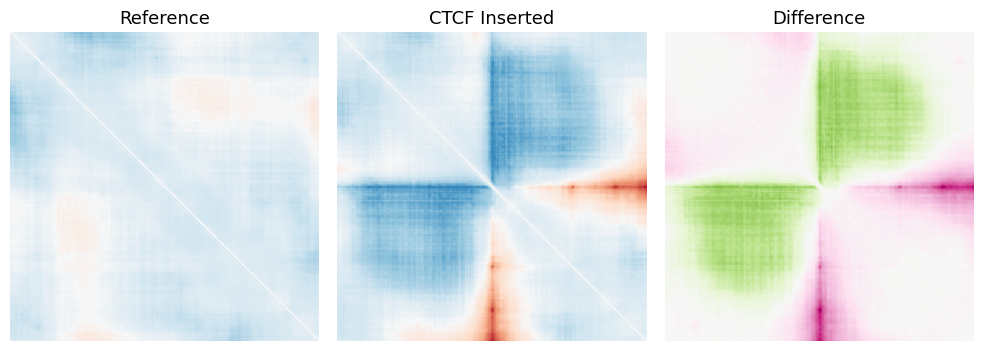

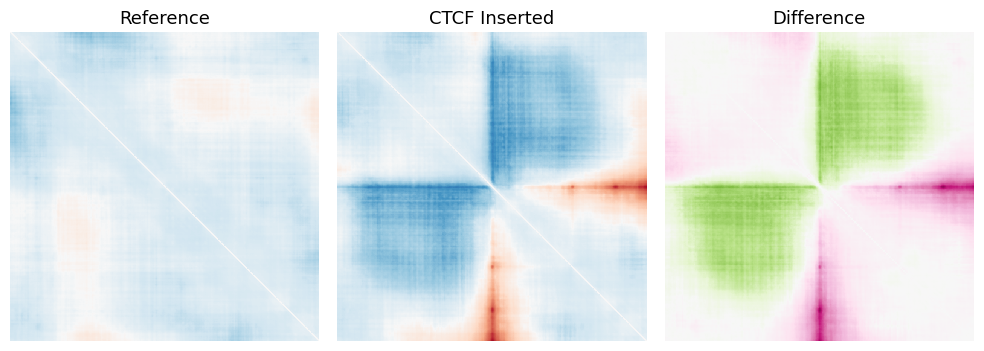

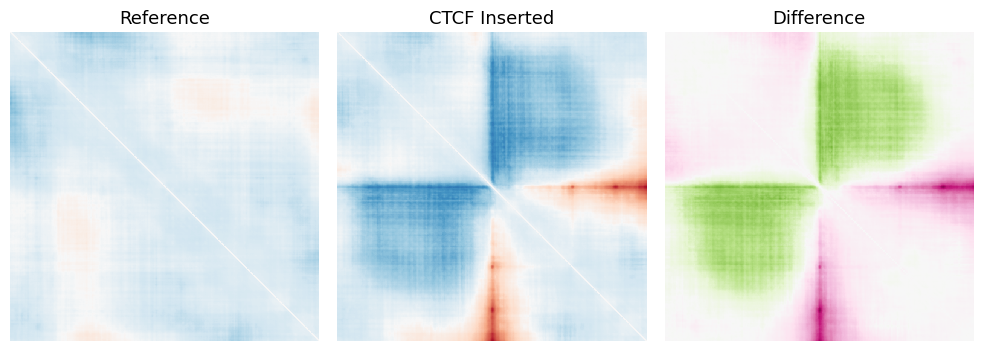

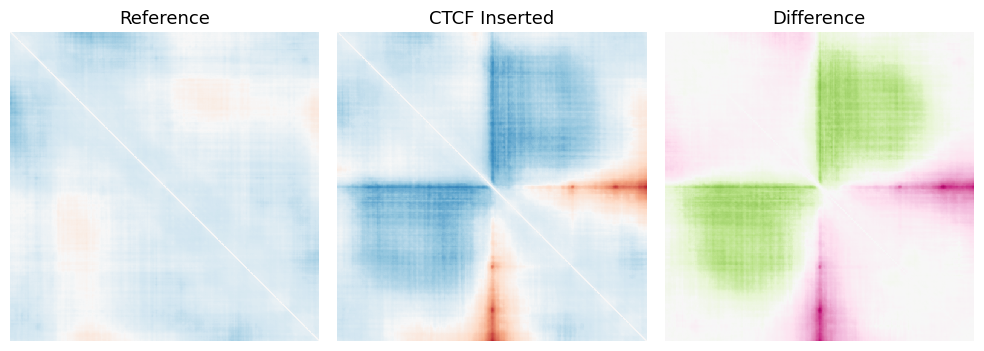

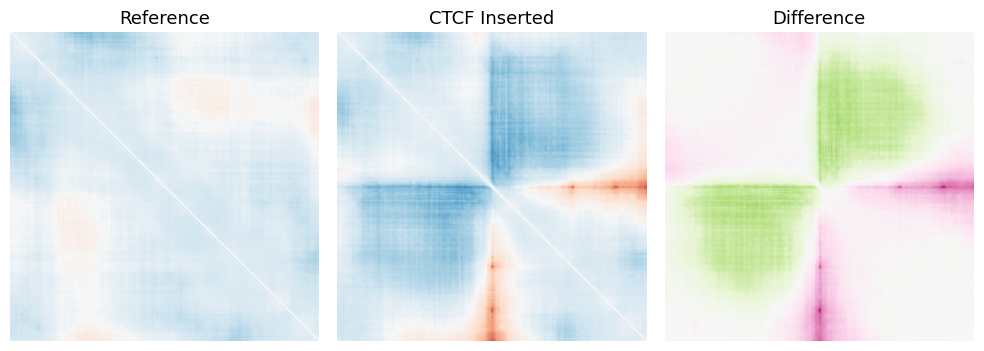

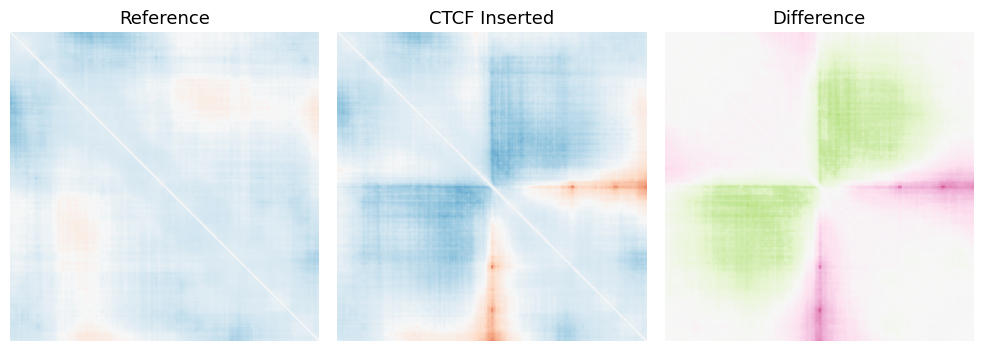

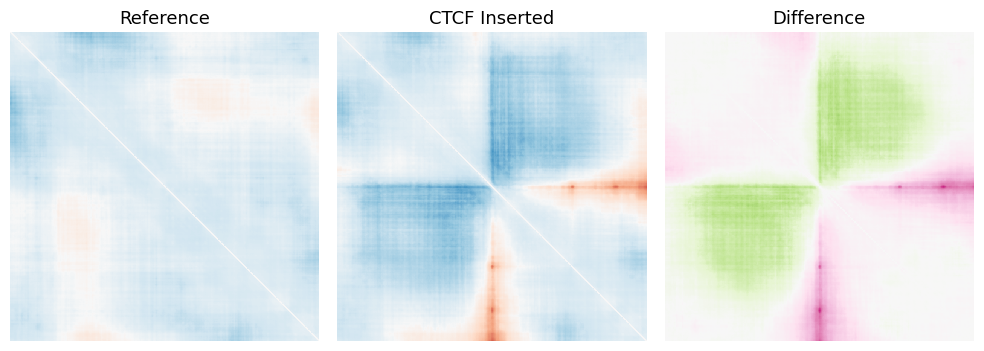

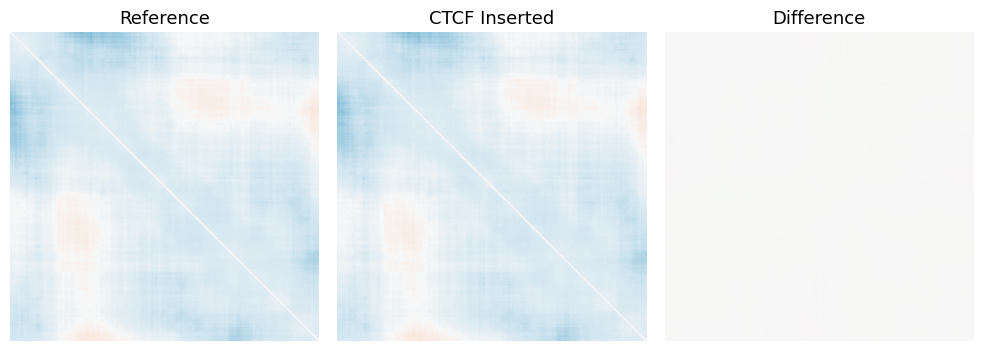

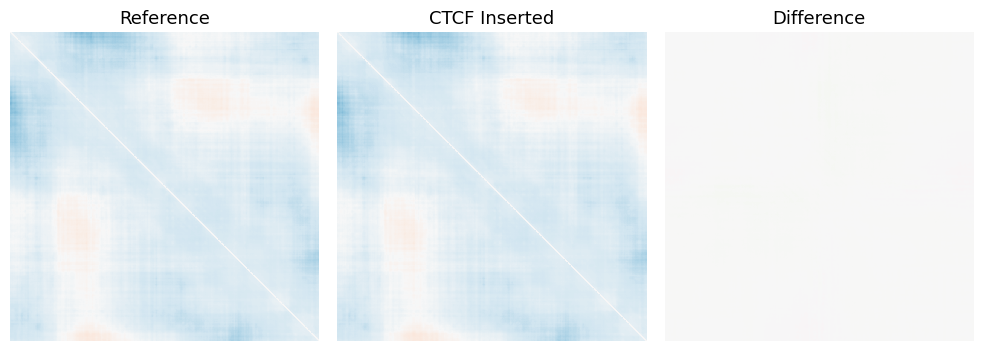

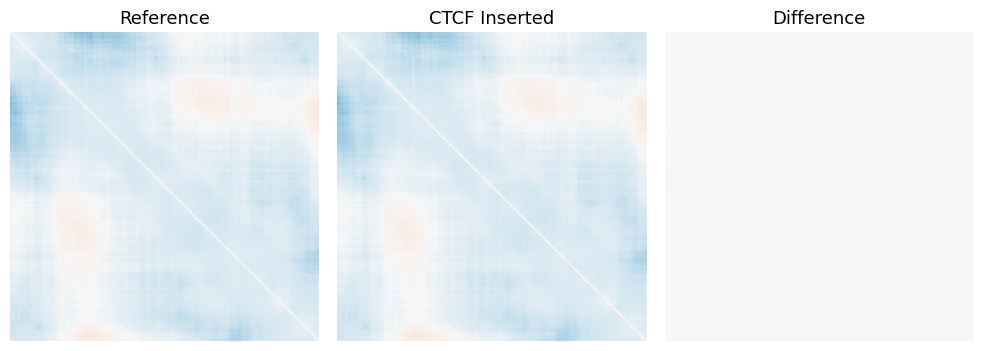

In [11]:
for exp_index in range(num_experiments):
    
    bg_index = seq_coords_df.iloc[exp_index].background_index

    prediction_matrix = preds_stream[exp_index]
    reference_prediction_matrix = backgrounds_predictions[bg_index, :, :]

    ref_maps = ut_dense(reference_prediction_matrix)
    alt_maps = ut_dense(prediction_matrix)

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[0]
    )
    axs[0].set_title('Reference')
    
    sns.heatmap(
        alt_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[1]
    )
    axs[1].set_title('CTCF Inserted')

    sns.heatmap(
        alt_maps[:,:,target_index]-ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="PiYG_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[2]
    )
    axs[2].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

In [12]:
genome_open.close()